# Figure 8: Plot a GP trained to estimate threshold curves derived from human participants. Compare against QCSF.

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Samyukta Jayakumar, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v2

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis


## Figure Description

For each patient, plot their threshold curve, and train a GP and QCSF model on actively sampled data points. Record the RMSE values for each patient, and create a spaghetti plot comparing ml-csf to qcsf.

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.

Canare, D., Ni, R., & Lu, T. (2019). An open-source implementation of the Quick CSF method. Journal of Vision, 19(10), 86b. https://doi.org/10.1167/19.10.86b

In [1]:
# Import libraries

from utility.utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import gpytorch as gp
import torch as pt
import sys
import seaborn as sns
import json
import datetime

import numpy as np
import matplotlib.lines as mlines
import json
import datetime
import pickle
import os
from QuickCSF import QuickCSF, simulate
%matplotlib inline

In [2]:
print("python version -->>", sys.version)
print("gpytorch version -->>", gp.__version__)
print("pytorch version -->>", pt.__version__)

python version -->> 3.10.9 (main, Mar  8 2023, 04:44:36) [Clang 14.0.6 ]
gpytorch version -->> 1.8.1
pytorch version -->> 1.13.1


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

## Define Constants

In [3]:
# Run-time flags

verb_mode = False               # print verbose analyses during runs?
show_figure = True              # plot final figure on screen?
save_figure = True              # save plots in indicated directory?

create_mlcsf_results = False    # run new results for mlcsf?
create_qcsf_results = False     # run new results for qcsf?
make_qcsf_gifs = True           # if creating results, save gifs for each run?

plot_canon = True               # plot canonical CSF spline-interpolated curves?
plot_thresh  = True             # plot 50% threshold curve of prior?
plot_qcsf = True                # plot qCSF for comparison?
plot_rmse = True                # plot rmses in figure?

In [4]:
# MLCSF Constant Declarations

# evaluation grid bounds in raw linear units
raw_freq_min = 0.5       # cycles per degree
raw_freq_max = 32        
raw_contrast_min = 1e-3  # contrast units
raw_contrast_max = 1     

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = .04  # guess rate is 4%
psi_lambda = .04  # lapse rate is 4%
psi_sigma = .08
sigmoid_type = 'logistic'

# training parameters
num_halton_samples = 8
num_initial_points_training_iters = 500
num_new_points = 92
num_new_points_training_iters = 150

# GP hyperparameters
min_lengthscale = 0.15
lr = .125
beta_for_regularization = 0.25

random_seed = 1

# define ghost points (they will have a label of 0, i.e., a color of red)
raw_freq_ghost_points = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 128]
raw_contrast_ghost_points = [5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1]

# other params to train_and_sample_gp method
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_entropy = True
calculate_posterior = True

SCHIZOPHRENIA = 'Schizophrenia'
NEUROTYPICAL = 'Neurotypical'
SCHIZOPHRENIA_short = 'SZ'
NEUROTYPICAL_short = 'NT'

data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp2.json'
data_file_path = f'{data_dir}{data_file_name}'

csf_curves_exp2 = load_json_from_file(data_file_path)

participants_by_phenotype = [
    (SCHIZOPHRENIA, csf_curves_exp2['schizophrenia_participants']),
    (NEUROTYPICAL, csf_curves_exp2['neurotypical_participants']),
]

prior_raw_freq_min = 0.5
prior_raw_freq_max = 64
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

top_level_results_dir = "./data/"
mlcsf_results_dir = f'{top_level_results_dir}figure_08/'


if verb_mode:
    print_training_iters = True
    print_training_hyperparameters = True
    progress_bar = True
else:
    print_training_iters = False
    print_training_hyperparameters = False
    progress_bar = False

# loads previous results if create_mlcsf_results=False
existing_mlcsf_results_timestamp = "2023-09-21_14-28-25" 

mean_module_name = 'constant_mean'

# enums
MLCSF = 'MLCSF'
QCSF = 'qCSF'
GROUNDTRUTH = 'ground truth'



In [5]:
# qCSF Constant Declarations
# Parameters not listed here are identical to mlcsf when creating qcsf results

qcsf_num_trials = 100
qcsf_random_seed = 2

# at how many number of datapoints to calculate time elapsed for qcsf
timepoints = [10, 20, 50, 100] 

d = 1   # 1-guess_rate used by qCSF model
qcsf_psi_gammma = 0
qcsf_psi_lambda = 0

qcsf_results_dir = f'{top_level_results_dir}qcsf_experiment_2/'
qcsf_gif_dir = f'analysis/gifs/qcsf_experiment_2/'
qcsf_gif_prefix = 'qcsf_'

# loads previous results if create_qcsf_results=False
existing_qcsf_results_timestamp = '2023-09-21_17-01-05' 

In [6]:
# Plotting parameters

###########
# GENERAL #
###########

num_rows = 5
num_cols = 4

fig_width = 14   # figure width
fig_height = 8  # figure height

dpi_val = 600  # graphics resolution

font_family = 'Arial'
plt.rcParams['font.family'] = font_family

suptitfontsiz = 16          # supertitle font size
titfontsiz = 14             # title font size
labfontsiz = 12             # label font size
ticfontsiz = 8              # tick font size
legfontsiz = 'small';       # legend font size
rmse_fontsiz = 8

suptitpad = 0.96            # supertitle padding size

suptitfontweight = 'roman'
titfontweight = 'roman'  # title font weight
labfontweight = 'roman'  # label font weight
ticfontweight = 'roman'  # tick font weight
legfontweight = 'roman'  # tick font weight

mean_color = "#4fd2c4"
latent_color = "dimgrey"
qcsf_color = "#6f116f"

latent_transparency_ratio = 1.0
qcsf_linestyle = 'dotted'

tick_line_length = 2

rmse_filename = 'rmses'

xlab_x_pos = 0.5
xlab_y_pos = 0.06
ylab_x_pos = 0.08
ylab_y_pos = 0.5

rmse_x_pos = 2.2
rmse_mlcsf_x_pos = 3.2
rmse_qcsf_x_pos = 4.0

rmse_y_pos = 2.4
qcsf_rmse_weight = 'bold'

legend_loc = (0.073, 0.084)
legend_font_size = 7

subplots_adjust_params = {
    'wspace':0.2, 
    'hspace':0.4
}

mean_dashes = (5.5, 3)

xticklab = [0.5, 2, 8, 32]
xtickval = logFreq().forward(np.array(xticklab))
yticklab = [1, 0.1, 0.01, 0.001]
ytickval = logContrast().forward(np.array(yticklab))
cbtickval = [0, 0.25, 0.5, 0.75, 1]
cbticklab = [0, 0.25, 0.5, 0.75, 1]

cb_pad = 0.05  # move coloarbar xx units horizontally
cblab_pad = -53  # move colorbar label xx units horizontally

num_spline_vals = 750  # number of interpolated points in spline curves

colmap='gist_gray'

ptit  = 'Estimated CSFs Compared to Ground Truth CSF'
xlab = 'Spatial Frequency (cyc/deg)'
ylab = 'Contrast'
cblab = 'Detection Probability'

plot_dir = 'analysis/figure_08/'
plot_filename = 'Figure08_ThresholdComparison'

##################
# SPAGHETTI PLOT #
##################

spaghetti_fig_size = (3.5, 4.4)
spaghetti_bbox_to_anchor = (1, 0.5)

spaghetti_xlim = [-0.5, 1.5] # was -0.5, 1.37
spaghetti_ylim = [0, 0.25]

spaghetti_y_lab = ''
spaghetti_xticks_values = [0, 1]
spaghetti_xticks_labels = [MLCSF, QCSF]
spaghetti_yticks_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]
spaghetti_yticks_ha = 'right'

spaghetti_line_linewidth = 1
spaghetti_line_alpha = 0.7
spaghetti_marker_s = 15
spaghetti_marker_alpha = 0.8
spaghetti_title = 'RMSE'

spaghetti_legend_loc = 'center left'
spaghetti_mlcsf_marker = 'o'
spaghetti_qcsf_marker = 'o'
spaghetti_mlcsf_zorder = 5
spaghetti_qcsf_zorder = 5

## Create MLCSF Results

In [7]:
# define how to transform the data
prior_freq_min = logFreq().forward(prior_raw_freq_min)
prior_freq_max = logFreq().forward(prior_raw_freq_max)
prior_contrast_min = logContrast().forward(prior_raw_contrast_max) # 1/x swaps min and max
prior_contrast_max = logContrast().forward(prior_raw_contrast_min)

def f(d):
    return scale_data_within_range(d, (0, 1), prior_freq_min, prior_freq_max, prior_contrast_min, prior_contrast_max)

# create ghost pts
ghost_x1 = logFreq().forward(np.array(raw_freq_ghost_points))
ghost_x2 = logContrast().forward(np.array(raw_contrast_ghost_points))
assert len(ghost_x1) == len(ghost_x2), "make sure that the ghost arrays have the same length"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

num_ghost_points = len(ghost_y)
            
# Transform raw bounds and create grid
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, x_resolution, y_resolution)

In [8]:
# RUN MCLSF

##################
# CODE VARIABLES #
##################

results = {}
results_to_save = {}
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

resultdir = f'{mlcsf_results_dir}{timestamp}/'
ensure_directory_exists(resultdir)

if not create_mlcsf_results:
    #############
    # LOAD DATA #
    #############
    
    timestamp = existing_mlcsf_results_timestamp
    
    resultdir = f'{mlcsf_results_dir}{existing_mlcsf_results_timestamp}/'
    filename = f"results_{existing_mlcsf_results_timestamp}.pkl"
    
    with open(resultdir + filename, 'rb') as file:
        results = pickle.load(file)
    
    random_seed = results[f"{SCHIZOPHRENIA_short}0"]['random_seed']
    set_random_seed(random_seed)
    
    
else:
    ###############
    #   SAVE BY   #
    # PARTICIPANT #
    ###############
    print(timestamp)
    filename = f'results_{timestamp}'

    for phenotype, participants in participants_by_phenotype:

        for i, participant in enumerate(participants):

            participant_label = f"{SCHIZOPHRENIA_short}{i}" if phenotype == SCHIZOPHRENIA else f"{NEUROTYPICAL_short}{i}"
            print(f"Participant {participant_label}")

            ###################
            # CONSTRUCT CURVE #
            ###################

            set_random_seed(random_seed)

            # prepare freqs - turn log10 to log2, and start from 0
            curve = np.array(participant)
            curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
            left, right, bottom, top = get_data_bounds(curve)

            cs = create_cubic_spline(curve)

            ###################
            # ACTIVE LEARNING #
            ###################

            # create initial data points
            halton_X, halton_y = halton_samples_from_data(xx, yy, cs, psi_gamma, psi_lambda, num_halton_samples, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)

            initial_Xs = np.vstack((ghost_X, halton_X))
            initial_ys = np.hstack((ghost_y, halton_y))

            # model training
            set_random_seed(random_seed)

            model, likelihood, X, y, _, _, _, _ = sample_and_train_gp(
                cs,
                grid,
                xx,
                yy,
                sampling_strategy='active',
                mean_module_name=mean_module_name,
                psi_sigma=psi_sigma,
                sigmoid_type=sigmoid_type,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=lr,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_points,
                beta_for_regularization=beta_for_regularization,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                phi=f,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                progress_bar=progress_bar,
                min_lengthscale=min_lengthscale,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                initial_Xs=initial_Xs,
                initial_ys=initial_ys,
                num_ghost_points=num_ghost_points
            )

            #################
            # EVALUATE GRID #
            #################

            # transform evaluation grid so it can be used by GP
            grid_transformed = transform_dataset(grid, phi=f)

            # get the predictions on the eval grid
            Z = evaluate_posterior_mean(model, likelihood, grid_transformed)
            zz = Z.reshape(xx.shape)

            results[participant_label] = {
                'xx': xx,
                'yy': yy,
                'zz': zz,
                'X': X,
                'y': y,
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'model': model,
                'likelihood': likelihood,
                'f': f,
                'random_seed': random_seed
            }
    
            # save results_to_save dictionary w/out model and other unstoreable things
            results_to_save[participant_label] = results[participant_label].copy()

            # some pytorch things aren't compatible with pickle
            for key in ['model', 'likelihood', 'cs', 'f']:
                del results_to_save[participant_label][key]
            
            # save the model state and Xt
            Xt = transform_dataset(X, phi=f)
            torch.save(model.state_dict(), f'{resultdir}{filename}_{participant_label}_model_state.pth')
            torch.save(Xt, f'{resultdir}{filename}{participant_label}_Xt.pth')

    with open(f'{resultdir}{filename}.pkl', 'wb') as file:
        pickle.dump(results_to_save, file)

In [9]:
# RUN QCSF

if not create_qcsf_results:
    #############
    # LOAD DATA #
    #############
    
    qcsf_timestamp = existing_qcsf_results_timestamp

else:

    # parameters to run QuickCSF simulation
    simulationParams = {
        'trials': qcsf_num_trials,
        'stimuli': {
            'minContrast': raw_contrast_min,
            'maxContrast': raw_contrast_max,
            'contrastResolution': xs,
            'minFrequency': raw_freq_min,
            'maxFrequency': raw_freq_max,
            'frequencyResolution': ys,
        },
        'parameters': None,
        'd': d,             
        'psiGamma': qcsf_psi_gammma,
        'psiLambda': qcsf_psi_lambda,
        'psiSigma': psi_sigma,
        "sigmoidType": sigmoid_type,
        'timepoints': timepoints,
        'showPlots': False  # prevents plt from plotting every run 
    }

    # create new dir using datetime
    qcsf_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print("Timestamp:", qcsf_timestamp)

    # setup directories
    gifPath = f"{qcsf_gif_dir}{qcsf_gif_prefix}{qcsf_timestamp}/"
    if not os.path.exists(qcsf_results_dir): os.mkdir(qcsf_results_dir)

    resultsObject = {
        'datetime': qcsf_timestamp,
        **simulationParams
    }

    for phenotype, participants in participants_by_phenotype:

        for i, participant in enumerate(participants):
            if phenotype == SCHIZOPHRENIA:
                participant_label = f"{SCHIZOPHRENIA_short}{i}"
            else:
                participant_label = f"{NEUROTYPICAL_short}{i}"
            
            print(f"Participant {participant_label}")

            curve = np.array(participant)
            imagePath = f"{gifPath}{participant_label}/" if make_qcsf_gifs else None

            rmses, times, params = simulate.runSimulation(
                trueThresholdCurve=curve,
                imagePath=imagePath,
                randomSeed=qcsf_random_seed,
                **simulationParams)

            expResults = {
            "random_seed": qcsf_random_seed,
            "rmses": rmses,
            "times": times,
            "params": params, 
            }

            if participant_label not in resultsObject:
                resultsObject[participant_label] = [expResults]
            else:
                resultsObject[participant_label].append(expResults)

            if make_qcsf_gifs: create_gif(imagePath)

            filename = f'results_{qcsf_timestamp}.json'
            ensure_directory_exists(qcsf_results_dir)
            with open(qcsf_results_dir + filename, 'w') as file:
                json.dump(resultsObject, file, indent=2)

In [10]:
mlcsf_filename = f'{mlcsf_results_dir}{timestamp}/results_{timestamp}.pkl'
with open(mlcsf_filename, 'rb') as file:
    results = pickle.load(file)

qcsf_filename = f'{qcsf_results_dir}results_{qcsf_timestamp}.json'
with open(qcsf_filename, 'r') as file:
    qcsf_results_object = json.load(file)

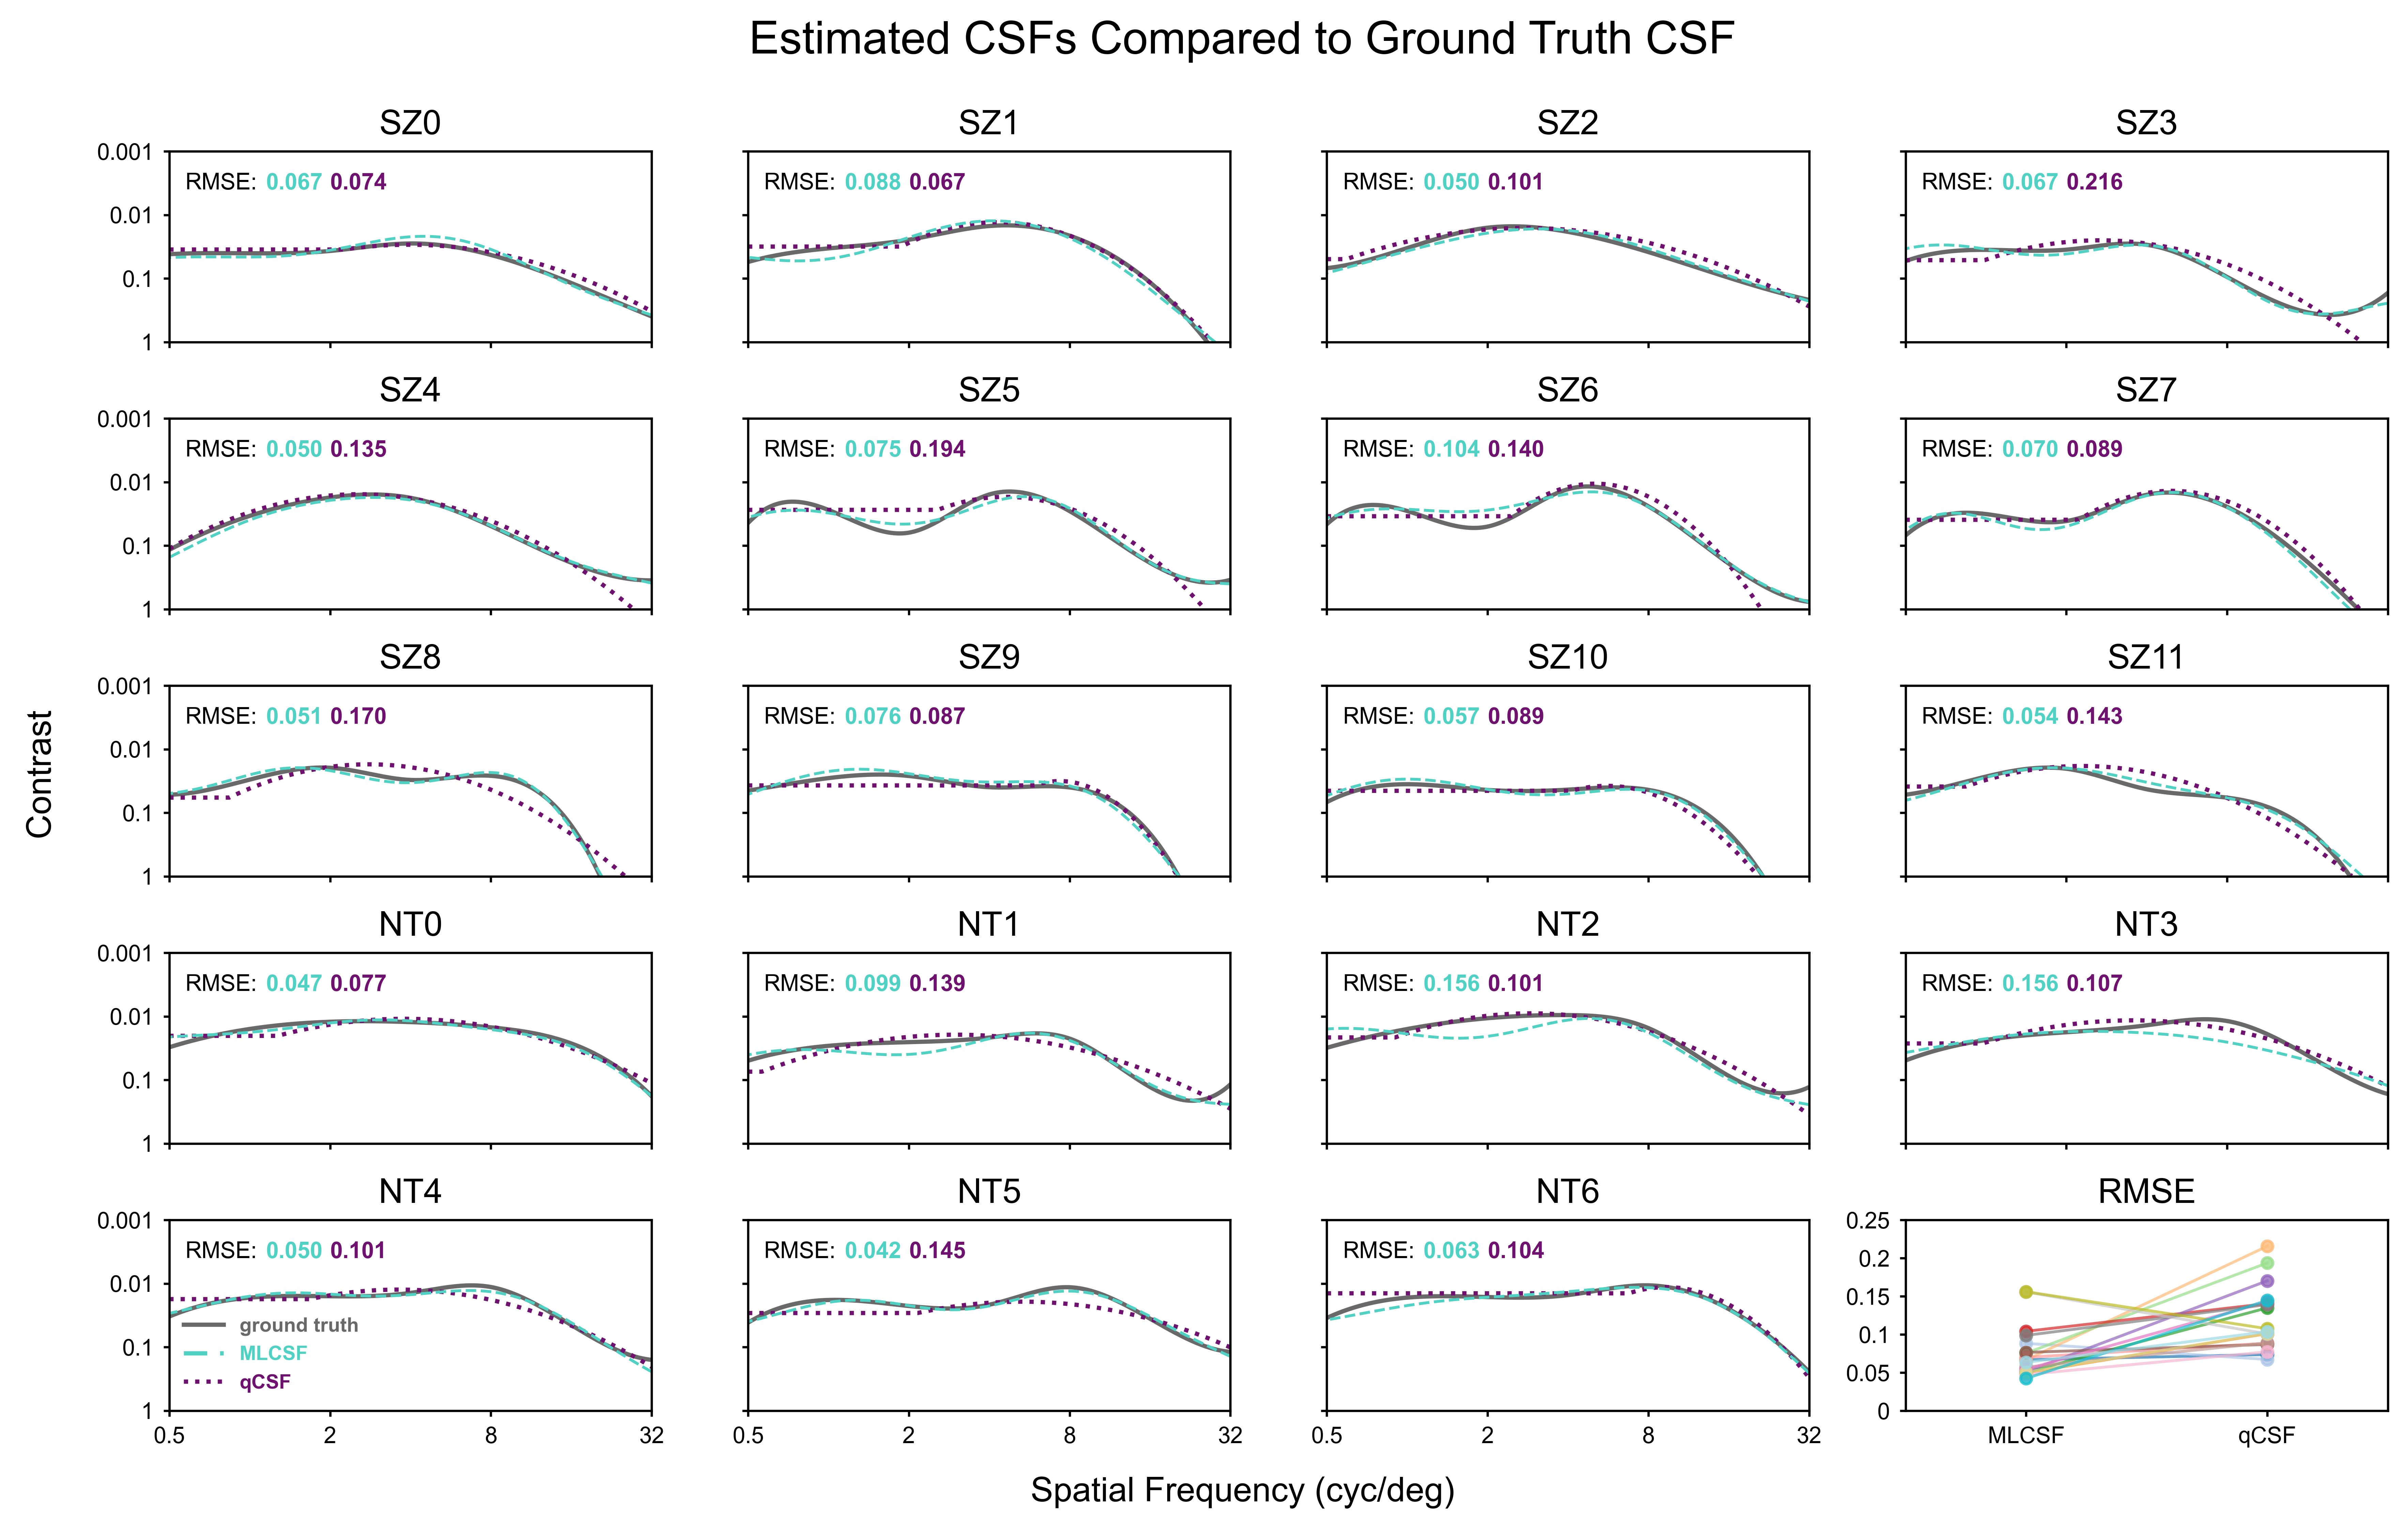

In [11]:
# testing loaded nvp data is enough to plot

fig, axs = plt.subplots(num_rows, num_cols, figsize=[fig_width, fig_height], dpi=dpi_val)
    
fig_idx = 0

for phenotype, participants in participants_by_phenotype:
    for i, participant in enumerate(participants):

        ax = axs[fig_idx // num_cols, fig_idx % num_cols]
        
        #############
        # LOAD DICT #
        #############
        
        participant_label = f"{SCHIZOPHRENIA_short}{i}" if phenotype == SCHIZOPHRENIA else f"{NEUROTYPICAL_short}{i}"
        mlcsf_results_object = results[participant_label]
        
        xx = mlcsf_results_object['xx']
        yy = mlcsf_results_object['yy']
        zz = mlcsf_results_object['zz']
        X = mlcsf_results_object['X']
        y = mlcsf_results_object['y']
        left = mlcsf_results_object['left']
        right = mlcsf_results_object['right']
        top = mlcsf_results_object['top']
        bottom = mlcsf_results_object['bottom']
        
        # get cubic spline
        curve = np.array(participant)
        curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
        cs = create_cubic_spline(curve)
        
        psi_sigma = mlcsf_results_object['psi_sigma']
        psi_gamma = mlcsf_results_object['psi_gamma']
        psi_lambda = mlcsf_results_object['psi_lambda']
        x_min = mlcsf_results_object['x_min']
        x_max = mlcsf_results_object['x_max']
        y_min = mlcsf_results_object['y_min']
        y_max = mlcsf_results_object['y_max']
        xs = mlcsf_results_object['xs']
        ys = mlcsf_results_object['ys']
        grid = mlcsf_results_object['grid']

        # plot the spline
        if plot_canon:
            if phenotype == SCHIZOPHRENIA: right += 1 # TODO hardcoded
            latent_x1 = np.linspace(left, right, num_spline_vals) 
            latent_x2 = cs(latent_x1)
            ax.plot(latent_x1, latent_x2, color=latent_color, alpha=latent_transparency_ratio)

        # plot the qcsf
        if plot_qcsf:
            qcsf_freq = logFreq().inverse(latent_x1)
            qcsf_map = qcsf_results_object[participant_label][0]
            qcsf_params_map = qcsf_map["params"]

            qcsf_contrast = QuickCSF.csf(
                qcsf_params_map["peakSensitivity"],
                qcsf_params_map["peakFrequency"],
                qcsf_params_map["bandwidth"],
                qcsf_params_map["delta"],
                qcsf_freq).reshape(-1)
            ax.plot(latent_x1[qcsf_contrast > 0], qcsf_contrast[qcsf_contrast > 0], color=qcsf_color, linestyle=qcsf_linestyle)

        # plot mlcsf
        if plot_thresh:
            level = (1 - psi_lambda + psi_gamma) / 2
            CS = ax.contour(xx, yy, zz, levels=[level], linestyles=['dashed'], \
                            linewidths=[1], colors=[mean_color])

        # plot rmse in each subplot
        if plot_rmse:
            mlcsf_rmse = getRMSE(xx, yy, zz, level, cs)
            qcsf_rmse = qcsf_map["rmses"][-1]

            ax.text(rmse_x_pos, rmse_y_pos, "RMSE:", fontsize=rmse_fontsiz) 
            
            mlcsf_rmse_text = ax.text(rmse_mlcsf_x_pos, rmse_y_pos, f"{mlcsf_rmse:.3f}", fontsize=rmse_fontsiz, color=mean_color, fontweight='bold')
            qcsf_rmse_text = ax.text(rmse_qcsf_x_pos, rmse_y_pos, f"{qcsf_rmse:.3f}", fontsize=rmse_fontsiz, color=qcsf_color, fontweight='bold')

        # subplot settings
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        ax.set_title(participant_label)
        
        fig_idx += 1

# tick labels
plt.setp(axs, xticks=xtickval, xticklabels=xticklab, yticks=ytickval, yticklabels=yticklab)

for i, ax in enumerate(axs.flat):
    ax.tick_params(axis='both', which='major', direction='out', labelsize=ticfontsiz, length=tick_line_length)

    if i != num_rows*num_cols-1:
        ax.label_outer() # only include outer ticks for threshold subplots
    
    else:  # plot the spaghetti plot on the bottom right corner
        
        data = []

        total_participants = 0
        for phenotype, participants in participants_by_phenotype:
            for i, participant in enumerate(participants):
                total_participants += 1

                #############
                # LOAD DICT #
                #############

                participant_label = f"{SCHIZOPHRENIA_short}{i}" if phenotype == SCHIZOPHRENIA else f"{NEUROTYPICAL_short}{i}"
                mlcsf_results_object = results[participant_label]

                xx = mlcsf_results_object['xx']
                yy = mlcsf_results_object['yy']
                zz = mlcsf_results_object['zz']
                X = mlcsf_results_object['X']
                y = mlcsf_results_object['y']
                left = mlcsf_results_object['left']
                right = mlcsf_results_object['right']
                top = mlcsf_results_object['top']
                bottom = mlcsf_results_object['bottom']
                psi_gamma = mlcsf_results_object['psi_gamma']
                psi_lambda = mlcsf_results_object['psi_lambda']

                # get cubic spline
                curve = np.array(participant)
                curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
                cs = create_cubic_spline(curve)

                qcsf_map = qcsf_results_object[participant_label][0]

                level = (1 - psi_lambda + psi_gamma) / 2

                mlcsf_rmse = getRMSE(xx, yy, zz, level, cs)

                qcsf_rmse = qcsf_map["rmses"][-1]

                data.append((mlcsf_rmse, qcsf_rmse, participant_label))

        colormap = plt.cm.gist_ncar
        ax.set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, total_participants))))
                    
        for d in data:
            line, = ax.plot([MLCSF, QCSF], d[:-1], label=d[2], linewidth=spaghetti_line_linewidth, alpha=spaghetti_line_alpha)
            ax.scatter(MLCSF, d[0], color=line.get_color(), marker=spaghetti_mlcsf_marker, zorder=spaghetti_mlcsf_zorder, s=spaghetti_marker_s, alpha=spaghetti_marker_alpha)  # Circle at the start point
            ax.scatter(QCSF, d[1], color=line.get_color(), marker=spaghetti_qcsf_marker, zorder=spaghetti_qcsf_zorder, s=spaghetti_marker_s, alpha=spaghetti_marker_alpha)

        ax.set_ylabel(spaghetti_y_lab, fontsize=labfontsiz)
        ax.set_xlim(spaghetti_xlim)
        ax.set_ylim(spaghetti_ylim)

        ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.set_xticks(ticks=spaghetti_xticks_values, labels=spaghetti_xticks_labels)
        ax.set_yticks(ticks=spaghetti_yticks_values, labels=spaghetti_yticks_values, ha=spaghetti_yticks_ha)
        ax.tick_params(length=tick_line_length)
        ax.set_title(spaghetti_title)

# spacing
plt.subplots_adjust(**subplots_adjust_params)
        
# title and axis labels
plt.suptitle(ptit, fontsize=suptitfontsiz, fontweight=suptitfontweight, y=suptitpad)
fig.text(xlab_x_pos, xlab_y_pos, xlab, ha='center', va='center', fontsize=labfontsiz)
fig.text(ylab_x_pos, ylab_y_pos, ylab, ha='center', va='center', rotation='vertical', fontsize=labfontsiz)

# legend
latent = mlines.Line2D([], [], color=latent_color, label=GROUNDTRUTH, alpha=latent_transparency_ratio)
mean = mlines.Line2D([], [], color=mean_color, dashes=mean_dashes, label=MLCSF)
qcsf = mlines.Line2D([], [], color=qcsf_color, linestyle=qcsf_linestyle, label=QCSF)
legend = fig.legend(handles=[latent, mean, qcsf], loc=legend_loc, fontsize=legend_font_size, frameon=False)

legend.get_texts()[0].set_color(latent_color)
legend.get_texts()[1].set_color(mean_color)
legend.get_texts()[2].set_color(qcsf_color)

legend.get_texts()[0].set_weight('bold')
legend.get_texts()[1].set_weight('bold')
legend.get_texts()[2].set_weight('bold')

# save the figure
if save_figure:
    ensure_directory_exists(plot_dir)
    plt.savefig(f'{plot_dir}{plot_filename}.png', bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f'{plot_dir}{plot_filename}.pdf', bbox_inches='tight', dpi=dpi_val)

if show_figure:
    plt.show()
plt.clf()